In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,7)

# 1- Feauture Engineering

### We will begin by importing the data into a pandas data frame and examining the data

In [2]:
df = pd.read_csv("Telecom-Usage-Details.csv")
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### We notice somethings here:
1. SeniorCitizen Column has the Dtype of int64 although it's a categorical variable
2. TotalCharges values are not numerical

We will start analyzing the data and fixing these issues.

In the TotalCharges some records are " ", we will replace them with 0 and change the column to numeric values.

In the SeniorCitizen column we will replace 1 values with "yes" and 0 values with "no".

In [4]:
replace_empty_with_0 = lambda x: "0" if x[0] ==" " else x
df.TotalCharges = df.TotalCharges.apply(replace_empty_with_0)
df.TotalCharges = pd.to_numeric(df.TotalCharges)

encode_SeniorCitizen = lambda x: "yes" if x ==1 else "no"
df.SeniorCitizen = df.SeniorCitizen.apply(encode_SeniorCitizen)

In [5]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


#### Now all the features are the correct type, we will then make sure that we don't have any duplicate customerID or any duplicate values

In [6]:
df = df.dropna()
len(df.customerID.value_counts())

7043

## First added feature, total number of add on services

In [7]:
df_services = df.iloc[:,6:14]
df_services

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV
0,No,No phone service,DSL,No,Yes,No,No,No
1,Yes,No,DSL,Yes,No,Yes,No,No
2,Yes,No,DSL,Yes,Yes,No,No,No
3,No,No phone service,DSL,Yes,No,Yes,Yes,No
4,Yes,No,Fiber optic,No,No,No,No,No
...,...,...,...,...,...,...,...,...
7038,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes
7039,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes
7040,No,No phone service,DSL,Yes,No,No,No,No
7041,Yes,Yes,Fiber optic,No,No,No,No,No


### Suppose we call 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies' Add on internet services
We will calculate the number of add-on services each customer has and study the relationship between that and the churn

In [8]:
df_addon = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']]
service_counter = lambda x: 1 if x =="Yes" else 0

df_addon = df_addon.applymap(service_counter)

In [9]:
import numpy as np
n_of_addon_services = np.sum(np.asarray(df_addon),axis=1)
df["n_of_addon_services"] = n_of_addon_services

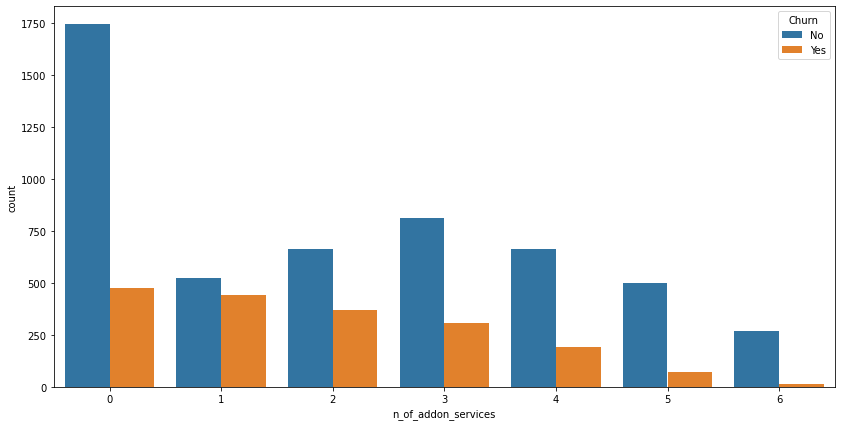

In [10]:
sns.countplot(x="n_of_addon_services", hue="Churn", data=df)

### we see that the more services our custoner has, the less likely they are to leave. However we can represent this plot in a different way. We will plot the *percentage* rather than the *number* of churn in users with the same number of addon services on the y-axis so we can see the relationship more clearly

In [11]:
df_n_of_services = df.groupby(['n_of_addon_services','Churn']).agg({'customerID': 'count'})
calc_pct = lambda x: round(100 * x / float(x.sum()),2)
Churn_percentages =df_n_of_services.groupby(level=0).apply(calc_pct)
Churn_percentages

customerID
n_of_addon_services Churn            
0                   No          78.59
                    Yes         21.41
1                   No          54.24
                    Yes         45.76
2                   No          64.18
                    Yes         35.82
3                   No          72.63
                    Yes         27.37
4                   No          77.70
                    Yes         22.30
5                   No          87.57
                    Yes         12.43
6                   No          94.72
                    Yes          5.28

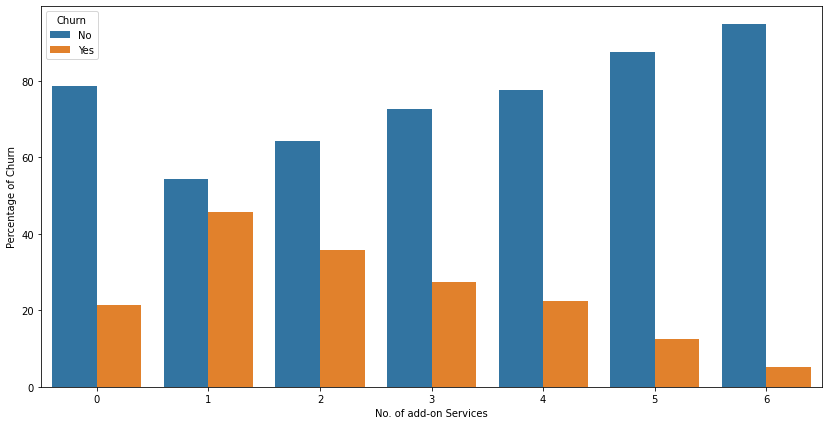

In [12]:
Churn_percentages = Churn_percentages.reset_index()
Churn_percentages.columns = ['No. of add-on Services', 'Churn', 'Percentage of Churn']
sns.barplot(x = 'No. of add-on Services', y = 'Percentage of Churn', hue = 'Churn', data = Churn_percentages)

From this graph we can tell that the more services a customer has, the less likely to churn. Except for customers who have 0 add-on services (phone-only customers).

## Second Feature, Customer Segmentation based on customer's Tenure and TotalCharges

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df[["tenure", "TotalCharges"]]
y = df["customerID"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We begin by scaling Customer tenurity on the x-axis and customer total charges on the y-axis so our clustering could run more efficiently

### In my opinion 6 clusters is the most logical option
The six clusters provide a good indication of customer's tenurity vs. their value we will begin applying labels to these clusters and we will analyze more

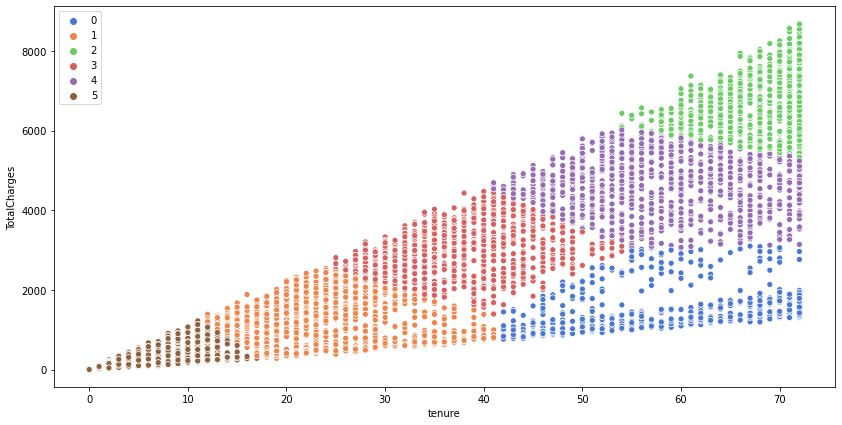

In [14]:
model_6 = KMeans(n_clusters=6, init="k-means++")
y = model_6.fit_predict(X_scaled)
sns.scatterplot(x = "tenure", y="TotalCharges", hue=y, data=df,legend="full", palette="muted")

In [62]:
my_dict = {
    0:"high Ten/low Val",
    1:"int Ten/low-int Val",
    2:"high Ten/High Val",
    3:"int Ten/int Val",
    4:"high Ten/high-int Val",
    5:"low Ten/low Val"
}

customerSegment = []
for i in y:
    customerSegment.append(my_dict[int(i)])

df["customerSegment"] = customerSegment

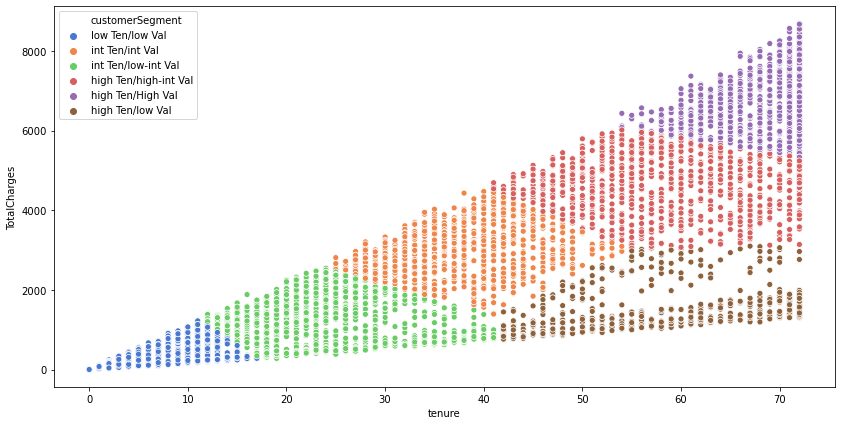

In [63]:
sns.scatterplot(x = "tenure", y="TotalCharges", hue="customerSegment", data=df,legend="full", palette="muted")

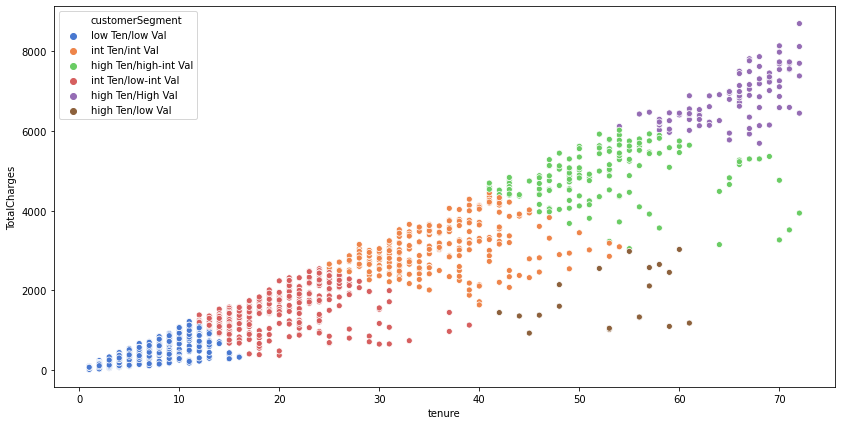

In [64]:
sns.scatterplot(x = "tenure", y="TotalCharges", hue="customerSegment", data=df[df.Churn == "Yes"],legend="full", palette="muted")

## This plot shows customers who churned and their segment
### We can see that some customer segments are more likely to churn than others

In [65]:
df_segmented = df.groupby(['customerSegment','Churn']).agg({'customerID': 'count'})
df_segmented

customerID
customerSegment       Churn            
high Ten/High Val     No            744
                      Yes            92
high Ten/high-int Val No            813
                      Yes           144
high Ten/low Val      No            646
                      Yes            19
int Ten/int Val       No            627
                      Yes           226
int Ten/low-int Val   No           1058
                      Yes           337
low Ten/low Val       No           1286
                      Yes          1051

### We will calculate the percentage of churn customers in each segment

In [66]:
calc_pct = lambda x: round(100 * x / float(x.sum()),2)
Churn_percentages =df_segmented.groupby(level=0).apply(calc_pct)
Churn_percentages

customerID
customerSegment       Churn            
high Ten/High Val     No          89.00
                      Yes         11.00
high Ten/high-int Val No          84.95
                      Yes         15.05
high Ten/low Val      No          97.14
                      Yes          2.86
int Ten/int Val       No          73.51
                      Yes         26.49
int Ten/low-int Val   No          75.84
                      Yes         24.16
low Ten/low Val       No          55.03
                      Yes         44.97

### We can say here that our most at risk customers are:
1. Low tenurity and low value customers (44.97% churn rate)
2. Intermediate Tenurity and Intermediate value customers (26.49% churn rate)
3. Intermediate tenurity and low-intermediate value customers (24.16% churn rate)

### Our safest customers are:
1. High tenurity and low value customers (2.86% churn rate)
2. High tenurity and High value customers (11.00% churn rate)
3. High tenurity and high-intermediate value customers (15.05% churn rate)

It follows business logic that customers with the least churn are high tenurity and low value customers (ex. a sensior citizen who has only one line and has been with the company for a long time) and that customers with the highest churn rates are low tenurity and low value customers (ex. tourists buying single lines or people buying burner phones).

it's positive that most of the churn rates are happening in intermediate to low value customers. it follows logic that customers who are deeply investing in our service are less likely to leave.

### We will sort the clusters by the percentage of churn so we can get a nice graph

In [67]:
Churn_percentages = Churn_percentages.reset_index()
Churn_percentages = pd.concat([Churn_percentages[Churn_percentages['Churn'] == 'No'].sort_values('customerID'),Churn_percentages[Churn_percentages['Churn'] == 'Yes']])

In [68]:
Churn_percentages

,customerSegment,Churn,customerID
10,low Ten/low Val,No,55.03
6,int Ten/int Val,No,73.51
8,int Ten/low-int Val,No,75.84
2,high Ten/high-int Val,No,84.95
0,high Ten/High Val,No,89.00
4,high Ten/low Val,No,97.14
1,high Ten/High Val,Yes,11.00
3,high Ten/high-int Val,Yes,15.05
5,high Ten/low Val,Yes,2.86
7,int Ten/int Val,Yes,26.49


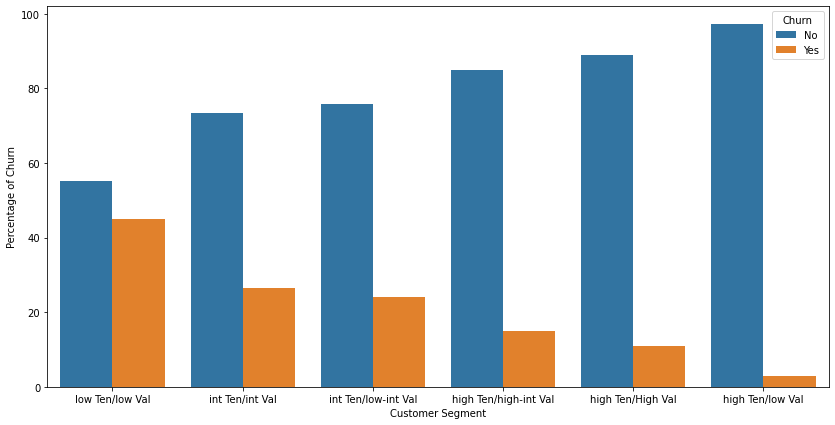

In [69]:
Churn_percentages = Churn_percentages
Churn_percentages.columns = ['Customer Segment', 'Churn', 'Percentage of Churn']
sns.barplot(x = 'Customer Segment', y = 'Percentage of Churn', hue = 'Churn', data = Churn_percentages)

From this graph we can say generally the more tenured the customer is, the less likely they are to churn

### Third Feature: the ratio of monthly charges to total charges

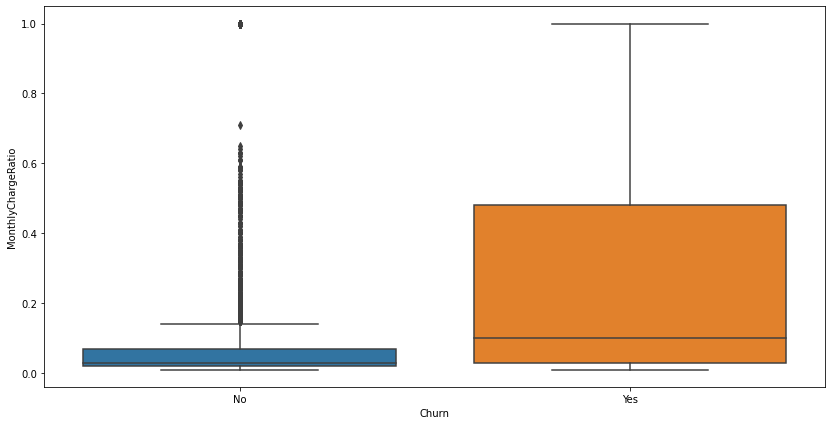

In [23]:
charge_ratio_calculator = lambda row: round(row['MonthlyCharges']/(row['TotalCharges']+1e-2),2) if row['TotalCharges'] >1 else 1
df['MonthlyChargeRatio'] = df.apply(charge_ratio_calculator, axis=1)
sns.boxplot(x = 'Churn',y ='MonthlyChargeRatio', data = df)

We can see that the churn customers tend to have a higher ratio of monthly charge/total charge. this could be interpreted as a result of them being generally less tenured

## Feature Selection

In [24]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'n_of_addon_services', 'customerSegment', 'MonthlyChargeRatio'],
      dtype='object')

In [25]:
encoded_df = df[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','n_of_addon_services', 'customerSegment']]
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
encoded_array = ordinal_encoder.fit_transform(encoded_df)

from itertools import count
j = count(start=0, step = 1)
for i in encoded_df.columns:
    encoded_df[i] = encoded_array[:,next(j)]

### We encoded all of our categorical Features
We give the categorical features numerical values so we can plug them in the model

In [26]:
encoded_df

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,n_of_addon_services,customerSegment
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,5.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,5.0,1.0
7039,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0,4.0,3.0
7040,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0
7041,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2.0


In [27]:
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[["tenure", "MonthlyCharges", "TotalCharges", "MonthlyChargeRatio"]])

### We also scaled the numerical features
We will now make a new df called processed_df with all of these processed values

In [28]:
processed_df = df.copy()
processed_df[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','n_of_addon_services', 'customerSegment']] = encoded_df.copy()
processed_df[["tenure", "MonthlyCharges", "TotalCharges", "MonthlyChargeRatio"]] = scaled_numeric.copy()

### We will then encode our target feature (Churn)

In [29]:
from sklearn.preprocessing import LabelEncoder
labelizer = LabelEncoder()
processed_df["Churn"] = labelizer.fit_transform(df["Churn"])

array(['No', 'Yes'], dtype=object)

## Making the train and test sets
Since the data is not equally distributed across the Churn and the customerSgement columns we have to respect that when we sample the data. We want our training and test sets to have the same distribution as the original dataset. for this purpose we will use stratified split.

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
for train_index, test_index in split.split(processed_df, processed_df["customerSegment"], processed_df["Churn"]):
    strat_train_set = processed_df.loc[train_index]
    strat_test_set = processed_df.loc[test_index]

In [31]:
strat_train_set.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'n_of_addon_services', 'customerSegment', 'MonthlyChargeRatio'],
      dtype='object')

In [32]:
X_train = strat_train_set[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'n_of_addon_services', 'customerSegment', 'MonthlyChargeRatio']]
y_train = strat_train_set['Churn']

X_test = strat_test_set[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'n_of_addon_services', 'customerSegment', 'MonthlyChargeRatio']]
y_test = strat_test_set['Churn']

## Feature Selection
We will use statsmodels logistic regression model and only keep features that are statistically significant to the model

In [33]:
import statsmodels.discrete.discrete_model as ds


model= ds.MNLogit(y_train,X_train)
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.412129
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                        MNLogit   Df Residuals:                     4908
Method:                           MLE   Df Model:                           21
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:                  0.2897
Time:                        17:39:33   Log-Likelihood:                -2031.8
converged:                       True   LL-Null:                       -2860.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
            Churn=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
gender                 -0.1004      0.078     -1.289      0.197      -0.253       0.052
SeniorCitizen           0.1814      0.101      1.789      0.074      -0.017       0.380
Partner                 0.0464      0.094      0.494      0.621      -0.137       0.230
Dependents             -0.1277      0.108     -1.178      0.239      -0.340       0.085
tenure                 -0.6124      0.191     -3.206      0.001      -0.987      -0.238
PhoneService           -1.1952      0.134     -8.930      0.000      -1.458      -0.933
MultipleLines           0.1047      0.046      2.285      0.022       0.015       0.195
InternetService         0.2921      0.165      1.771      0.077      -0.031       0.615
OnlineSecurity         -0.2663      0.090     -2.948      0.003      -0.443      -0.089
OnlineBackup           -0.1071      0.090     -1.190      0.234      -0.283       0.069
DeviceProtection       -0.1266      0.089     -1.422      0.155      -0.301       0.048
TechSupport            -0.2107      0.089     -2.379      0.017      -0.384      -0.037
StreamingTV             0.0333      0.082      0.405      0.686      -0.128       0.195
StreamingMovies         0.0216      0.083      0.260      0.795      -0.141       0.184
Contract               -0.7292      0.090     -8.060      0.000      -0.907      -0.552
PaperlessBilling        0.2910      0.090      3.246      0.001       0.115       0.467
PaymentMethod           0.0276      0.042      0.651      0.515      -0.055       0.111
MonthlyCharges          0.9605      0.155      6.194      0.000       0.657       1.264
TotalCharges            0.0468      0.191      0.245      0.806      -0.327       0.420
n_of_addon_services    -0.0201      0.166     -0.121      0.904      -0.346       0.306
customerSegment        -0.0044      0.028     -0.159      0.874      -0.058       0.050
MonthlyChargeRatio      0.3898      0.049      7.960      0.000       0.294       0.486
=======================================================================================
"""

In [34]:
def exclude_irrelevant_features(X,y):
    columns = list(X.columns)
    while len(columns) > 0:
        model= ds.MNLogit(y,X[columns])
        result=model.fit(disp=0)
        largest_pval = result.pvalues.nlargest(1,0)
        if float(largest_pval.iloc[0])> .05:
            col_name = largest_pval.index[0]
            columns.remove(col_name)
        else:
            break
    return columns

good_columns = exclude_irrelevant_features(X_train,y_train)

In [35]:
good_columns

['SeniorCitizen',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'MonthlyCharges',
 'MonthlyChargeRatio']

### This function will run the logistic regression model iteratively and each run it will exclude the feature with the highest p value from the list of features. Once all features have p value less than 5% the function will return a list of the remaining features
However, we will try to remove features that strongly correlate to one another so naive bayes can perform better

In [49]:
good_columns =['SeniorCitizen',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'MonthlyCharges',
 'customerSegment',
 'MonthlyChargeRatio']

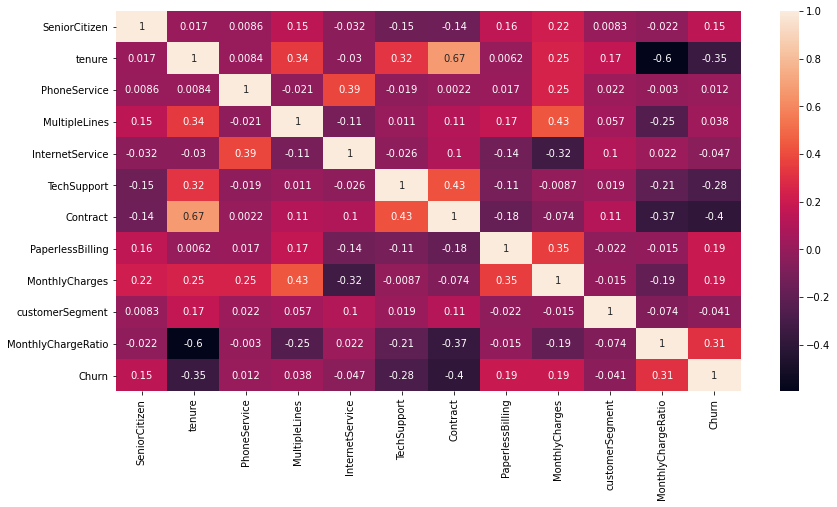

In [50]:
df_corr = processed_df[good_columns + ['Churn']]
corrMatrix = df_corr.corr()
sns.heatmap(corrMatrix, annot=True)

There's still some degree dependence between some of these features, for example monthly charge ratio and tenure, and number of addon services and internet service. these are mutually dependent variables. However, I experimented with and without them and the both models perform better with this set of features despite the dependence.

In [38]:
model= ds.MNLogit(y_train,X_train[good_columns])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.417752
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                        MNLogit   Df Residuals:                     4919
Method:                           MLE   Df Model:                           10
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:                  0.2800
Time:                        17:39:33   Log-Likelihood:                -2059.5
converged:                       True   LL-Null:                       -2860.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
           Churn=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
SeniorCitizen          0.2229      0.097      2.292      0.022       0.032       0.414
tenure                -0.6441      0.068     -9.526      0.000      -0.777      -0.512
PhoneService          -1.4215      0.119    -11.968      0.000      -1.654      -1.189
MultipleLines          0.0826      0.044      1.863      0.062      -0.004       0.169
InternetService        0.2824      0.073      3.844      0.000       0.138       0.426
TechSupport           -0.2762      0.049     -5.680      0.000      -0.372      -0.181
Contract              -0.8739      0.086    -10.171      0.000      -1.042      -0.705
PaperlessBilling       0.2696      0.081      3.316      0.001       0.110       0.429
MonthlyCharges         1.0369      0.058     17.785      0.000       0.923       1.151
customerSegment       -0.0220      0.026     -0.858      0.391      -0.072       0.028
MonthlyChargeRatio     0.4110      0.044      9.333      0.000       0.325       0.497
======================================================================================
"""

### These columns are the columns with the relevant pval (<5%) so we will only train our models on them
### We also notice that the correlation coefficient of these features are significantly high

## Making the the models
### Model 1: Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
model1 = LogisticRegression()
model1.fit(X_train[good_columns],y_train)
scores = cross_val_score(model1, X_test[good_columns], y_test, cv=5, scoring='f1_macro')
print(f"Accuracy: {round(scores.mean(),2)} (+/-{round(scores.std() * 2,2)}). Accuracy measured over 5 folds.")

Accuracy: 0.73 (+/-0.05). Accuracy measured over 5 folds.


### Model 2: Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

model2 = GaussianNB()
model2.fit(X_train[good_columns],y_train)
scores = cross_val_score(model2, X_test[good_columns], y_test, cv=5, scoring='f1_macro')
print(f"Accuracy: {round(scores.mean(),2)} (+/-{round(scores.std() * 2,2)}). Accuracy measured over 5 folds.")

Accuracy: 0.74 (+/-0.05). Accuracy measured over 5 folds.


# Comparing Naive Bayes and Logistic Regression

In [41]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(X_test[good_columns])[:,1])
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_test, model2.predict_proba(X_test[good_columns])[:,1])
auc2 = auc(fpr2, tpr2)

## here we calculate the false positive rate and the true positive rate fore each of our models
FPR is the rate of predictions that were classified as positive (in our case yes for churn) while they are actually negative. TPR are predictions that were classified as positive and they are actually positive.

We passed a list of probabilities for our positive (yes) class to the roc_curve function. the function calculates the FPR and TPR by setting different decision thresholds from 0 to 1 and classifying the points based on the probabilities we passed (above the threshold is positive and below the threshold is negative).

the auc is the area under the curve for each model. higher values indicate a better model

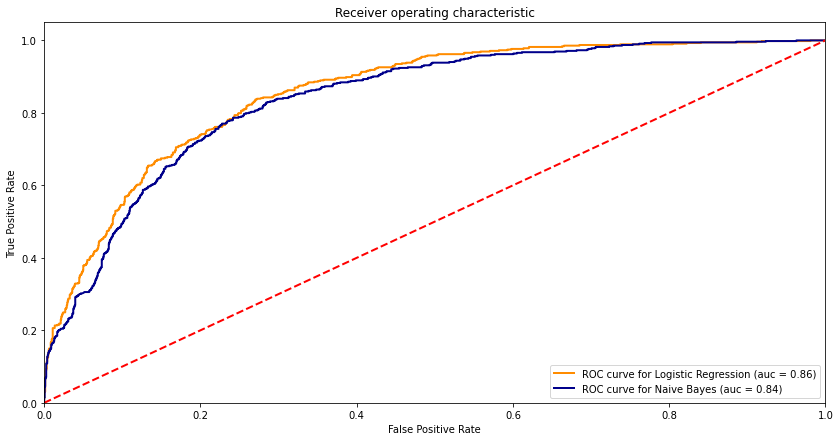

In [42]:
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='darkorange',lw=lw, label='ROC curve for Logistic Regression (auc = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, color='darkblue',lw=lw, label='ROC curve for Naive Bayes (auc = %0.2f)' % auc2)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

### Ploting the confusion matrices

In [43]:
import scikitplot as skplt
def confusion(y_test, y_predict):
    fig, ax = plt.subplots()

    skplt.metrics.plot_confusion_matrix(
        y_test, 
        y_predict,
        ax=ax)
    plt.show()

In [44]:
y_pred1 = model1.predict(X_test[good_columns])
accuracy_score(y_test, y_pred1)

0.8078561287269286

In [45]:
y_pred2 = model2.predict(X_test[good_columns])
accuracy_score(y_test, y_pred2)

0.7789872219592996

Logistic Regression


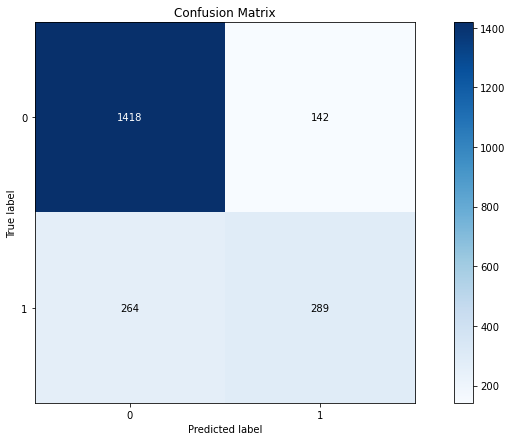

In [46]:
print('Logistic Regression')
confusion(y_test, y_pred1)

Naive Bayes


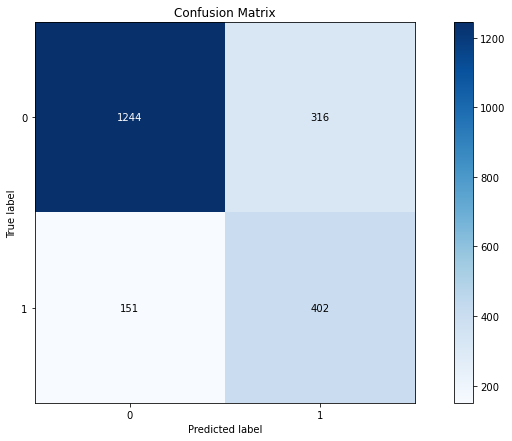

In [47]:
print('Naive Bayes')
confusion(y_test, y_pred2)

### We might be tempted to say that logistic regression performs better than naive bayes in this application. It has the better accuracy over 5 k-folds. it has the higher ROC curve AUC and it has better overall accuracy.

 ### However examining the confusion matrices reveals that Naive Bayes has a higher chance of predicting the positive class (Churn = yes) compared to logistic regression, while performing worse over the negative class. According to the business application, this information might affect which model we settle for.

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1, target_names=labelizer.classes_))

              precision    recall  f1-score   support

          No       0.84      0.91      0.87      1560
         Yes       0.67      0.52      0.59       553

    accuracy                           0.81      2113
   macro avg       0.76      0.72      0.73      2113
weighted avg       0.80      0.81      0.80      2113



In [53]:
print(classification_report(y_test, y_pred2, target_names=labelizer.classes_))

              precision    recall  f1-score   support

          No       0.89      0.80      0.84      1560
         Yes       0.56      0.73      0.63       553

    accuracy                           0.78      2113
   macro avg       0.73      0.76      0.74      2113
weighted avg       0.80      0.78      0.79      2113



## As we can see the f1-score for the 'Yes' class is higher in the naive bayes classifier. Which suggests it might be more useful in this business use case.